# Project Microeconometrics

Author: Benedikt Heinrich Müller, M.Sc. in Economics, Course Microeconometrics, Prof. Dr. Eisenhauer, University of Bonn, Summer term 2020
***

## Introductory Remarks 

In the following I replicate the findings of the 2011 empirical study "*Conscription and Crime: Evidence from the Argentine Draft Lottery*" by Galiani et al. (for exact citation see [section 1](#1.-Brief-Summary-of-the-Journal-Acticle)). Throughout I apply the same nomenclatur as did Galiani et al., i.e. the tables and figures are enumerated as in the original paper. The data set was well preprocessed. Therefore, replication of the results was straightforward and, hence, I replicate all the empirical figures contained in the paper and the online appendix.

## Content of this Notebook 

1. [Brief Summary of the Journal Article](#1.-Brief-Summary-of-the-Journal-Acticle)

    1.1 [Background & Data](#1.1-Background-&-Data)
    
    1.2 [Empirical Strategy](#1.2-Empirical-Strategy)

2. [Replication of Key Findings](#2.-Replication-of-Key-Findings)
3. [Extensions](#3.-Extensions)
4. [Critical Assessment of Quality](#4.-Critical-Assessment-of-Quality)

[References](#References)

### Import packages.

In [1]:
# Import packages.
import pandas as pd
import statsmodels.api as sm
import numpy as np

from scipy import stats
from sklearn import preprocessing
from linearmodels import IV2SLS

In [2]:
%matplotlib inline

In [3]:
#! cat environment_tutorial.yml

In [4]:
# Do I need to add this to the environment file.
#conda install -c conda-forge linearmodels

## 1. Brief Summary of the Journal Acticle

#### Full citation:

Galiani, Sebastian, Martín A. Rossi, and Ernesto Schargrodsky. 2011. "Conscription and Crime: Evidence from the Argentine Draft Lottery." *American Economic Journal: Applied Economics*, 3 (2): 119-36.
[DOI: 10.1257/app.3.2.119](http://dx.doi.org/10.1257/app.3.2.119)

 - Do they use individ.-level data? Yes, but they aggregate the data to the level of identical last three digits of the ID.
 - When did the cohorts 1958-1962 serve in the military?
 - Novel feature: Authors study effect of peacetime vs war-time military service on crimerate.
 - Crimerate is the same on the cohort-ID-level for each individ.
 - The authors study the effect of 

### 1.1 Background & Data

Conscription in Argentina has been subject to a draft lottery until the abolishment of mandatory conscription in the 1990s. Galiani et al. use this random assignment to estimate the causal effect of serving in the military on subsequent criminal behaviour.

#### The Argentine Draft Lottery 

The timing is as follows:
1. In an open session in the month of (?) the draft numbers are drawn. For every combination of the last three numbers of the national ID of all men in the birth cohort there is a draft number between 1 and 1,000 drawn.
2. The results of the lottery are publicly announced.
3. Medical examinations of all individuals in the birth cohort are conducted.
4. The exact cutoff number is publicly announced.
5. In the month of (?) individuals with a draft number higher than the cutoff which have passed the medical examination are drafted into the military. Draftees start service with 18 years.

To avoid confusion, note that in Angrist (1990) an individual was draft-eligible if he had a number *smaller* than the cutoff.

#### War and Peace 

The novelty of the study by Galiani et al. is that they not only estimate the effects of conspcription in wartime but also in peacetime. This is important out of two reasons: 1. the effects of conscription may differ on whether one served during war or peace and 2. peacetime service is more common than wartime service.

1. The effect of serving in the military may be quite different when exposed to actual combat. Those individuals envolved in combat may suffer from detrimental effects on their mental and physical health. These conditions may have a large impact on their subsequent criminal behaviour after serving in the military and may also lessen labour market outcomes.

2. Conscription during peacetime is more often the case than conscription during wartime. Galiani et al. note that most countries in the world have citizens drafted into military during peacetime. Thus, the effect of serving in the military in peacetime is the more relevant case when evaluating this policy.

From April to June 1982 there was the *Falklands War* between Argentina and the United Kingdom. The cohorts of 1962 and 1963 served during this war. Because of data availability, the authors considered the cohorts from 1958 to 1962 for their main analysis.

#### Data & Important Variables 

Galiani et al. use data provided by various Argentine administrative records.
Because of data privacy issues, they do not provide the raw data of their analysis. One observation in the data set stands for all individuals in the same birth cohort *c* and share the same last three digits of the national ID *i*.


In the following, I describe the most important variables used in the analysis.
The measure of criminal behaviour is the variable *crime rate*, which is also the dependent variable.
Let *n* be the number of individuals *j* in birth cohort *c*, with the same last three digits of their national ID *i*. Further, let $I(j)$ be an identity function returning *1* if individual *j* has a criminal record, and *0* otherwise. Then, *crime rate* is defined as
$$crimerate=\frac{ \sum_{j=1}^n I(j)}{n}$$
Note, that $I(j)$ does not indicate which kind of or how many crimes individual *j* commited. <br>
The variable whose effect the authors want to isolate is *conscription*, represented in the data set by *'sm'* (probably from Spanish *servicio militar*). *Conscription* is the share of individuals in *c* and *i* who served in the military. *Conscription* is probably endogenous and therefore instrumented for.
The potential instrument is the variable *draft eligible*, denoted in the data set by the dummy *'highnumber'*, which returns *1* if the draft number of *c* and *i* is above the cutoff number. The variable *draft number* is also available.
Potential control variables used are birth-cohort, origin (*argentine*, *naturalized*, and *indigenous*), and province dummies (federal states). The latter are denoted *dist* plus a number indicating one of the 24 provinces. The varible *malvinas* (Spanish name of the Falkland Islands) is a dummy which returns *1* if indidviduals of the cohort *c* served during the *Falklands War* in 1982 (for the main analysis only cohort 1962 served during the war).

### 1.2 Empirical Strategy

#### Causal Graph Representation 

I start the discussion of the empirical strategy by presenting the causal relationship Galiani et al. assumed in their study. To this end, I use the graphical representation suggested by Pearl (2014).

- Put navy and hn_malvinas into DAG.
- DAG: bdp and fd identification; fig. 4.9 b. in WM
 - Why we cannot use bd identification
- Subtle confounding: direct self-selection, accurate perception of individual treatment effect
 - Selection on unobs.: combi. of treatment effect heterogeneity and self-selection
- All back-door paths to be blocked that go from Z to D. See Nick Huntington-Klein.

#### Empirical Specification

In what follows, I employ the Potential Outcome framework as presented in Winship and Morgan (2014, p.xxy) in order to clarify the empirical stragtegy the paper is based upon. Potential issues concerning the identification of the causal relationship and crucial assumptions are discussed.

Galina et al. want to study the effect of serving in the military on subsequent criminal behaviour. They want to estimate the following regression (p. 127). Note that the notation presented here does not coincide with the one presented in the article. I adopted the notation used by Winship and Morgan (2014): $$Y_{ci} = \alpha + \delta D_{ci} + \gamma_{c} + \epsilon_{ci}$$
where
- $Y_{ci}$ denotes *crime rate*,
- $D$, denotes *conscription*,
- $\delta$, is the ATE,
- $\gamma_{c}$, a cohort effect, and
- $\epsilon_{ci}$, an error term.

Formally this amounts to  the following:
$$E[Y_{ci}] = E[\alpha + \delta D_{ci} + \gamma_{c} + \epsilon_{ci}] = \alpha + \delta E[D] + E[\epsilon_{ci}]$$

After some manipulation we arrive at
$$E[]$$

If the assumption $E[\epsilon∣D]=0$ holds, we can successfully identify the causal effect of $D$ on $Y$.
But, in the above described setting (see causal graph) it is possible that being actually drafted into the military is subject to some form of selection. Recall that all individuals in birth cohort *c* needed to attend medical examinations.
Failing the medical examination could be correlated with the socioeconomic background one has. There are various studies suggesting that health and socioeconomic status are associated (cite!). On the other hand, individuals with a high draft number, i.e. with a high probability of being drafted into the military, fail the medical examinations by purpose and are not being drafted into the military. One could imagine that well-placed individuals are more able to do so than individuals from other socioeconomic backgrounds.
Hence, we cannot ensure that in equation (get no.!) $$E[\epsilon∣D]=0$$
This endogeneity issue can be partially overcome by using an IV approach. A valid instrument needs to necessarily fulfil the following two conditions (this specification applies for the case of a binary instrument):
1. Exogeneity: $E[\epsilon∣Z]=0$
2. Relevance: $E[Z∣D]\neq 0$

After some manipulation we arrive at the Wald estimator
$$\hat{\delta}_{IV, Wald} = \frac{E[Y|Z=1]-E[Y∣Z=0]}{E[D|Z=1]-E[D|Z=0]}$$

The exogeneity condition cannot be tested statistically. One can only argue whether an instrument is uncorrelated to the error $\epsilon$. Condition 2 can be tested by means of estimating the effect from the instrument to the endogenous independent variable $D$. The effect needs to be large and statistically significant. Otherwise we would end up with a weak instrument, which would render the IV estimator useless.

In the light of essential individual heterogeneity though, the IV results cannot be interpreted as an ATE, i.e. $\delta$ is not constant in the population. This is the case, since we can only make statements about the causal relationship of individuals whose probability of treatment changes according to the IV. In the empirical investigation at hand this means that the estimated effect is the effect on the compliers only, i.e. the individuals who join the military because they are conerced of doing so by having a draft number higher than the cutoff. That is, the Wald estimator in this context converges in probabilty to $E[\delta |C=c]$

Note on condition of monotonicity.

Policy relevance of the instrument. We are fine, since we also test the draft lottery as a policy.

## 2. Replication of Key Findings

- Call out which of the findings are really key.
 - Exclusion restriction met? Can only argue that this holds.
 - Relevancy ensured?
 - Direction of bias.

#### Import data from .dta-file.

In [5]:
# Load Stata file into a pandas DataFrame: Crime.dta
path = (r'C:\Users\admin\Documents\Studium\Semester_4\Microeconometrics\Project_Galinai_et_al._2011\Dataset-AEJApp-2010-0001\Crime.dta')
df = pd.read_stata(path)

In [6]:
# For the regressions below, add a constant to the data frame.
df['constant'] = 1
# Get a variable representing the string constant.
constant = ['constant']
# Same for 'highnumber' and 'sm'.
highnumber = ['highnumber']
conscription = ['sm']
crimerate = ['crimerate']
malvinas = ['malvinas']
navy = ['navy']
# Get list of origin dummy names. Omit 'argentine' i.o.t. avoid multicollinearity.
origin = ['naturalized', 'indigenous']

In [7]:
# Get list of cohort dummy names.
cohort_years = list(range(1930, 1966, 1))  # Omit cohort_1929 (multicollinearity).
cohorts = []
for i in cohort_years:
    cohorts.append('cohort_' + f'{i}')

In [8]:
# Get list of district dummy names. District dummies have already been provided in data.
district_numbers = list(range(2, 25, 1))  # Omit dist1 (multicollinearity).
districts = []
for i in district_numbers:
    districts.append('dist' + f'{i}')

In [9]:
# Generate cohort dummies.
# Define a function that creates a dummy for a given cohort.
def get_cohort_dummy(df, col, c):
    '''
    Inputs are
    a DataFrame,
    a column col (string), and
    an input c (cohort) for which the output variable shall return 1.
    newcol
    '''
    # Create name of column for cohort c.
    newcol = 'cohort_' + f'{c}'
    # Define a function that creates a dummy var. conditional on another column.
    def dummy_mapping(x):
        if x == c:
            return 1
        elif x == np.nan:
            return np.nan
        else:
            return 0
    df[newcol] = df[col].apply(dummy_mapping)

In [10]:
# Generate variable hn_malvinas: inteaction term between highnumber and malvinas.
df['hn_malvinas'] = df.highnumber*df.malvinas
hn_malvinas = ['hn_malvinas']

In [11]:
get_cohort_dummy(df=df, col='cohort', c=1927)

In [12]:
df['cohort_1927'].value_counts()

0    49000
1     1000
Name: cohort_1927, dtype: int64

In [13]:
df['cohort_1927'].describe()

count    50000.000000
mean         0.020000
std          0.140001
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: cohort_1927, dtype: float64

In [14]:
pd.crosstab(df.cohort_1927, df.cohort[df.cohort < 1940][df.cohort > 1920])

cohort,1927.0,1928.0,1929.0,1930.0,1931.0,1932.0,1933.0,1934.0,1935.0,1936.0,1937.0,1938.0,1939.0
cohort_1927,,,,,,,,,,,,,
0,0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
1,1000,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
df = df.drop(labels='cohort_1927', axis=1)

In [16]:
# Get cohort dummies from 1929 to 1965. Alternatively use OneHotEncoding.
for year in list(range(1929, 1966, 1)):
    get_cohort_dummy(df=df, col='cohort', c=year)

In [17]:
df.head()

,idnumber,cohort,draftnumber,navy,malvinas,military,crimerate,cl_claselow2,falselow2,formal,...,cohort_1956,cohort_1957,cohort_1958,cohort_1959,cohort_1960,cohort_1961,cohort_1962,cohort_1963,cohort_1964,cohort_1965
0,0.0,1927.0,445.0,0.0,0,0.0,0.064294,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1927.0,397.0,0.0,0,0.0,0.027555,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1927.0,659.0,0.0,0,0.0,0.036739,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,3.0,1927.0,781.0,0.0,0,0.0,0.045924,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,4.0,1927.0,205.0,0.0,0,0.0,0.018370,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


### Table 1 - Availability of Data by Birth Cohort 

Table 1 on p. xxy gives an overview of the data available to the authors. The 2SLS approach uses the data o the years 1958 through 1962, since for these cohorts data on actual conspription status is available.

### Table 2 - Differences in Pre-Treatment Characteristics by Birth Cohort and Eligibility Group

We want to compute t test statistics in order to ensure that pre-treatment characterictics are the same across draft eligible and draft exempt indiviuals.

by cohorttests: ttest argentine, by(highnumber) unequal

by cohorttests: ttest indigenous, by(highnumber) unequal

by cohorttests: ttest naturalized, by(highnumber) unequal

Maybe changing nan_policy yiields correct values.

In [18]:
# Get statistics for cohort 1958 for argentine.
a = df.argentine[df.highnumber == 0][df.cohort == 1958]
b = df.argentine[df.highnumber == 1][df.cohort == 1958]
stats.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='propagate')
# equal_var = False since the authors allow for unequal variances across the groups. Why is this good practice?

Ttest_indResult(statistic=-0.07953373199691331, pvalue=0.9366708296999757)

In [19]:
# Get statistics for cohort 1958 for indigenous.
a = df.indigenous[df.highnumber == 0][df.cohort == 1958]
b = df.indigenous[df.highnumber == 1][df.cohort == 1958]
stats.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='propagate')
# equal_var = False since the authors allow for unequal variances across the groups. Why is this good practice?

Ttest_indResult(statistic=-0.14980859455270507, pvalue=0.8810374950973898)

In [20]:
# Now in a for loop.
cohort = list(range(1958, 1963, 1))
for d in ['argentine', 'indigenous', 'naturalized']:
    print('***')
    print(f'{d.capitalize()}')
    for c in cohort:
        a = df[d][df.highnumber == 0][df.cohort == c]
        b = df[d][df.highnumber == 1][df.cohort == c]
        ttest = stats.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='propagate')
        tstat = ttest.statistic
        pval = ttest.pvalue
        standard_error = tstat/pval
        print(f'Year {c}: t-statistic = {tstat:.4f}, standard error = {standard_error:.4f}')
        print(f'p-value: {pval:.4f}')

***
Argentine
Year 1958: t-statistic = -0.0795, standard error = -0.0849
p-value: 0.9367
Year 1959: t-statistic = -0.1376, standard error = -0.1545
p-value: 0.8906
Year 1960: t-statistic = -1.0550, standard error = -3.6150
p-value: 0.2918
Year 1961: t-statistic = -0.1874, standard error = -0.2201
p-value: 0.8514
Year 1962: t-statistic = 0.2661, standard error = 0.3367
p-value: 0.7903
***
Indigenous
Year 1958: t-statistic = -0.1498, standard error = -0.1700
p-value: 0.8810
Year 1959: t-statistic = -0.1539, standard error = -0.1754
p-value: 0.8777
Year 1960: t-statistic = 0.7176, standard error = 1.5162
p-value: 0.4733
Year 1961: t-statistic = -0.4717, standard error = -0.7402
p-value: 0.6373
Year 1962: t-statistic = 0.6425, standard error = 1.2338
p-value: 0.5208
***
Naturalized
Year 1958: t-statistic = 0.7054, standard error = 1.4657
p-value: 0.4813
Year 1959: t-statistic = 0.1514, standard error = 0.1721
p-value: 0.8797
Year 1960: t-statistic = 0.9337, standard error = 2.6615
p-value:

### Table 3 - First Stage by Birth Cohort 

#### Table 3 column (1)

In [21]:
cohorts[29: 33]

['cohort_1959', 'cohort_1960', 'cohort_1961', 'cohort_1962']

In [70]:
# Define endogenous and exogenous data.
# Due to multicollinearity issues leave out dummy for '58
indep_vars = [highnumber + cohorts[29: 33] + constant]
df_regression = df[df.cohort > 1957][df.cohort < 1963].copy()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [71]:
df_regression.shape

(5000, 91)

In [72]:
X = df_regression[highnumber + cohorts[29: 33] + constant].copy()
y = df_regression.loc[:, 'sm']

In [83]:
# Fit and summarise OLS model.
model = sm.OLS(y, X)  # Use the implementation of R when reconsidering this code.

rslts = model.fit()

df_regression['fitted_conscription'] = rslts.fittedvalues
#print(rslts.summary())
print('Parameter values:')
print(round(rslts.params, 4))  # Get array of these values (not rounded) by adding .values.
print('White robust standard errors:')
print(round(rslts.HC0_se, 4))
print(len(y))

Parameter values:
highnumber     0.6587
cohort_1959   -0.0191
cohort_1960   -0.0001
cohort_1961    0.0483
cohort_1962    0.0201
constant       0.0323
dtype: float64
White robust standard errors:
highnumber     0.0012
cohort_1959    0.0024
cohort_1960    0.0018
cohort_1961    0.0017
cohort_1962    0.0019
constant       0.0017
dtype: float64
5000


In [88]:
df_regression[['highnumber', 'cohort', 'sm', 'fitted_conscription']].head(20)

,highnumber,cohort,sm,fitted_conscription
31000,0.0,1958.0,0.044118,0.032299
31001,1.0,1958.0,0.665339,0.691045
31002,1.0,1958.0,0.660793,0.691045
31003,1.0,1958.0,0.676991,0.691045
31004,0.0,1958.0,0.055794,0.032299
31005,1.0,1958.0,0.689815,0.691045
31006,0.0,1958.0,0.032787,0.032299
31007,1.0,1958.0,0.648649,0.691045
31008,1.0,1958.0,0.706977,0.691045
31009,1.0,1958.0,0.741228,0.691045


#### Table 3 column (2) - (6)

In [26]:
# Define endogenous and exogenous data.
years = list(range(1958, 1963, 1))
for i in years:
    df_regression = df[df.cohort == i].copy()
    X = df_regression[['highnumber', 'constant']].copy()
    y = df_regression.loc[:, 'sm']
    # Fit and summarise OLS model.
    OLS = sm.OLS(y, X)  # Use the implementation of R when reconsidering this code.
    rslts = OLS.fit()
    #print()
    print(f'\n Cohort {i}')
    print(50*'*')
    print(round(rslts.params, 4))  # Get array of these values (not rounded) by adding .values.
    print(round(rslts.HC0_se, 4))  # These are White’s (1980) heteroskedasticity robust standard errors.
    #Same used by Galiani et al.


 Cohort 1958
**************************************************
highnumber    0.6279
constant      0.0578
dtype: float64
highnumber    0.0033
constant      0.0030
dtype: float64

 Cohort 1959
**************************************************
highnumber    0.6210
constant      0.0389
dtype: float64
highnumber    0.0027
constant      0.0008
dtype: float64

 Cohort 1960
**************************************************
highnumber    0.6505
constant      0.0377
dtype: float64
highnumber    0.0018
constant      0.0008
dtype: float64

 Cohort 1961
**************************************************
highnumber    0.6972
constant      0.0556
dtype: float64
highnumber    0.0017
constant      0.0011
dtype: float64

 Cohort 1962
**************************************************
highnumber    0.6853
constant      0.0343
dtype: float64
highnumber    0.0019
constant      0.0007
dtype: float64


- Discuss rregression results. Note on validity of the instrument.

### Table 4 - Estimated Impact of Conscription on Crime Rates 

#### Table 4 column (1) - (4)

In [27]:
df_reg = df[df.cohort > 1957][df.cohort < 1963].copy()
# Dependent variable: Crime rate
y = df_reg.loc[:, 'crimerate']

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [28]:
# Get set of independent variables.
# 'no_controls' refers to the case where we have cohort controls only.

vars_controls = highnumber + cohorts[29: 33] + origin + districts + constant
vars_no_controls = highnumber + cohorts[29: 33] + constant

X_controls = df_reg[vars_controls].copy()
X_no_controls = df_reg[vars_no_controls].copy()
# In statsmodels we need to add a constant by hand:
#X_controls = sm.add_constant(X_controls, prepend=False)
#X_no_controls = sm.add_constant(X_no_controls, prepend=False)

#### a. OLS Results

Caution: What does the 'absorb' attribute in Stata areg mean? Do I need to take this into account?

Column (1): Independent variable is *Draft eligible* (highnumber).

In [29]:
OLS = sm.OLS(y, X_no_controls)  # Use the implementation of R when reconsidering this code.
rslts = OLS.fit()
print(f'OLS Results. Cohort controls only.')
#print()
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params[0], 4))  # Get array of these values (not rounded) by adding .values.
#print()
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se[0], 4))

OLS Results. Cohort controls only.

 Coefficient estimate for Draft eligible (highnumber).
0.0018

 White robust standard error Draft eligible (highnumber).
0.0006


Column (2): Independent variable is *Draft eligible* (highnumber). Controls for origin and district included.

In [30]:
OLS = sm.OLS(y, X_controls)  # Use the implementation of R when reconsidering this code.
rslts = OLS.fit()
print(f'OLS Results. Cohort, origin and district controls included.')
#print()
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params[0], 4))  # Get array of these values (not rounded) by adding .values.
#print()
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se[0], 4))

OLS Results. Cohort, origin and district controls included.

 Coefficient estimate for Draft eligible (highnumber).
0.0018

 White robust standard error Draft eligible (highnumber).
0.0006


#### b. 2SLS Results

Column (3): Independent variable is *Conscription* (sm), instrumented by *Draft Eligible* (highnumber).

In [31]:
iv = IV2SLS(y, df_reg[constant + cohorts[29: 33]], df_reg['sm'], df_reg['highnumber'])
# Input of IV2SLS: dependent, exog, endog, instruments, *, weights=None
rslts = iv.fit()
print(f'2SLS Results. Cohort controls only.')
print(rslts)  # By default White standard errors.
#print('Coefficient estimate for Conscription (sm).')
#print(round(rslts.params[0], 4))  # Get array of these values (not rounded) by adding .values.
#print()
#print('White robust standard error Conscription (sm).')
#print(round(rslts.HC0_se[0], 4))

2SLS Results. Cohort controls only.
                          IV-2SLS Estimation Summary                          
Dep. Variable:              crimerate   R-squared:                      0.0038
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0028
No. Observations:                5000   F-statistic:                    21.804
Date:                Tue, Jul 07 2020   P-value (F-stat)                0.0006
Time:                        18:00:24   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
constant        0.0674     0.0008     89.905     0.0000      0.0660      0.0689
cohort_1959 

Column (4): Independent variable is *Conscription* (sm), instrumented by *Draft Eligible* (highnumber). Controls for origin and district included.

In [32]:
iv = IV2SLS(y, df_reg[constant + cohorts[29: 33] + origin + districts], df_reg['sm'], df_reg['highnumber'])
rslts = iv.fit()
print(f'2SLS Results. Cohort, origin and district controls included.')
print(rslts)
#print('Coefficient estimate for Conscription (sm).')
#print(round(rslts.params[0], 4))  # Get array of these values (not rounded) by adding .values.
#print()
#print('White robust standard error Conscription (sm).')
#print(round(rslts.HC0_se[0], 4))

2SLS Results. Cohort, origin and district controls included.
                          IV-2SLS Estimation Summary                          
Dep. Variable:              crimerate   R-squared:                      0.0181
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0121
No. Observations:                5000   F-statistic:                    95.774
Date:                Tue, Jul 07 2020   P-value (F-stat)                0.0000
Time:                        18:00:24   Distribution:                 chi2(30)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
constant        0.0626     0.0055     11.477     0.0000      0.0519

#### Table 4 columns (5) - (7)

#### Column (5): 1929 - 1965 

In [33]:
# Since we are considering data from 1929 through 1965, we need to adapt the data frame.
df_cohorts_29_65 = df[df.cohort > 1928][df.cohort < 1966][highnumber + constant + cohorts + crimerate].copy().dropna(axis=0)

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [34]:
X = df_cohorts_29_65[highnumber + constant + cohorts]
y = df_cohorts_29_65.loc[:, 'crimerate']

In [35]:
model = sm.OLS(y, X)
rslts = model.fit()

print(f'OLS Results. Cohort controls only.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))

OLS Results. Cohort controls only.

 Coefficient estimate for Draft eligible (highnumber).
0.0006

 White robust standard error Draft eligible (highnumber).
0.0003


#### Column (6): 1929 - 1955 

In [36]:
# Since we are considering data from 1929 through 1955, we need to adapt the data frame.
df_cohorts_29_55 = df[df.cohort > 1928][df.cohort < 1956].copy()
df_cohorts_29_55 = df_cohorts_29_55[highnumber + constant + cohorts + crimerate]
df_cohorts_29_55 = df_cohorts_29_55.dropna(axis=0)  # Drop NaNs.

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [37]:
X = df_cohorts_29_55[highnumber + constant + cohorts]
y = df_cohorts_29_55.loc[:, 'crimerate']

In [38]:
model = sm.OLS(y, X)
rslts = model.fit()

print(f'OLS Results. Cohort controls only.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))

OLS Results. Cohort controls only.

 Coefficient estimate for Draft eligible (highnumber).
0.0003

 White robust standard error Draft eligible (highnumber).
0.0004


#### Column (7): 1958 - 1965 

In [39]:
# Since we are considering data from 1958 through 1965, we need to adapt the data frame.
df_cohorts_58_65 = df[df.cohort > 1957][df.cohort < 1966].copy()
df_cohorts_58_65 = df_cohorts_58_65[highnumber + constant + cohorts[29:36] + crimerate]
df_cohorts_58_65 = df_cohorts_58_65.dropna(axis=0)  # Drop NaNs.

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [40]:
X = df_cohorts_58_65[highnumber + constant + cohorts[29:36]]
y = df_cohorts_58_65.loc[:, 'crimerate']

In [41]:
model = sm.OLS(y, X)
rslts = model.fit()

print(f'OLS Results. Cohort controls only.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))

OLS Results. Cohort controls only.

 Coefficient estimate for Draft eligible (highnumber).
0.0012

 White robust standard error Draft eligible (highnumber).
0.0004


- Compare OLS (appendix table A.4) and 2SLS (table 4, columns 3 & 4) results: in which direction does the bias go?
- Get 'Percent change' (see notes on table 4)

### Table 5 - Estimated Impact of Conscription on Crime Rates for Peacetime versus Wartime Service and 1-Year versus 2-Year Service

#### Table 5 column (1) & (2)

Column (1): 1929 - 1965

In [42]:
df_29_65 = df[df.cohort > 1928][df.cohort < 1966][highnumber + hn_malvinas + constant + cohorts[0:36] + crimerate].copy().dropna(axis=0)
X = df_29_65[highnumber + hn_malvinas + constant + cohorts[0:36]].copy()
y = df_29_65.loc[:, 'crimerate']

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [43]:
model = sm.OLS(y, X)
rslts = model.fit()
print(f'OLS Results.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 6))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))
print('\n Coefficient estimate for Eligible during Malvinas War (malvinas).')
print(round(rslts.params['hn_malvinas'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (malvinas).')
print(round(rslts.HC0_se['hn_malvinas'], 4))
print(f'\n Number of observations: {len(y)}')

OLS Results.

 Coefficient estimate for Draft eligible (highnumber).
0.000475

 White robust standard error Draft eligible (highnumber).
0.0003

 Coefficient estimate for Eligible during Malvinas War (malvinas).
0.0015

 White robust standard error Draft eligible (malvinas).
0.0009

 Number of observations: 34904


Column (2): 1958 - 1965

In [44]:
df_58_65 = df[df.cohort > 1957][df.cohort < 1966][highnumber + hn_malvinas + constant + cohorts[29:36] + crimerate].copy().dropna(axis=0)
X = df_58_65[highnumber + hn_malvinas + constant + cohorts[29:36]].copy()
y = df_58_65.loc[:, 'crimerate']

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [45]:
model = sm.OLS(y, X)
rslts = model.fit()
print(f'OLS Results.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))
print('\n Coefficient estimate for Eligible during Malvinas War (hn_malvinas).')
print(round(rslts.params['hn_malvinas'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Eligible during Malvinas War (hn_malvinas).')
print(round(rslts.HC0_se['hn_malvinas'], 4))
print(f'\n Number of observations: {len(y)}')

OLS Results.

 Coefficient estimate for Draft eligible (highnumber).
0.0009

 White robust standard error Draft eligible (highnumber).
0.0005

 Coefficient estimate for Eligible during Malvinas War (hn_malvinas).
0.0011

 White robust standard error Eligible during Malvinas War (hn_malvinas).
0.001

 Number of observations: 7928


#### Table 5 column (3) & (4)

Column (3): 1928 - 1965

In [46]:
df_29_65 = df[df.cohort > 1928][df.cohort < 1966][highnumber + navy + constant + cohorts[0:36] + crimerate].copy().dropna(axis=0)
X = df_29_65[highnumber + navy + constant + cohorts[0:36]].copy()
y = df_29_65.loc[:, 'crimerate']

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [47]:
model = sm.OLS(y, X)
rslts = model.fit()
print(f'OLS Results.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 6))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))
print('\n Coefficient estimate for Eligible for Navy (navy).')
print(round(rslts.params['navy'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Eligible for Navy (navy).')
print(round(rslts.HC0_se['navy'], 4))
print(f'\n Number of observations: {len(y)}')

OLS Results.

 Coefficient estimate for Draft eligible (highnumber).
0.000539

 White robust standard error Draft eligible (highnumber).
0.0003

 Coefficient estimate for Eligible for Navy (navy).
0.0007

 White robust standard error Eligible for Navy (navy).
0.0003

 Number of observations: 34904


Column (4): 1958 - 1965

In [48]:
df_58_65 = df[df.cohort > 1957][df.cohort < 1966][highnumber + navy + constant + cohorts[29:36] + crimerate].copy().dropna(axis=0)
X = df_58_65[highnumber + navy + constant + cohorts[29:36]].copy()
y = df_58_65.loc[:, 'crimerate']

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [49]:
model = sm.OLS(y, X)
rslts = model.fit()
print(f'OLS Results.')
print('\n Coefficient estimate for Draft eligible (highnumber).')
print(round(rslts.params['highnumber'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Draft eligible (highnumber).')
print(round(rslts.HC0_se['highnumber'], 4))
print('\n Coefficient estimate for Eligible for Navy (navy).')
print(round(rslts.params['navy'], 4))  # Get array of these values (not rounded) by adding .values.
print('\n White robust standard error Eligible for Navy (navy).')
print(round(rslts.HC0_se['navy'], 4))
print(f'\n Number of observations: {len(y)}')

OLS Results.

 Coefficient estimate for Draft eligible (highnumber).
0.001

 White robust standard error Draft eligible (highnumber).
0.0004

 Coefficient estimate for Eligible for Navy (navy).
0.0011

 White robust standard error Eligible for Navy (navy).
0.0006

 Number of observations: 7928


## 3. Extensions 

Local IV would have been an appealing extension to this model. Unfortunately this is possible only, if one observes the strength of the instrument on selecting into the treatment. This is not the case here. The instrument *Draft Eligible* is a dummy variable, thus, there is no way of getting a measure of how large the incentives are to actually selecting into the treatment.

- Local IV instead of conventional IV. See [lecture](https://microeconometrics.readthedocs.io/lectures/generalized-roy-model/notebook.html#Estimation-strategies) from 16 June 2020.
- Bootstrapped standard errors? Are they biased in case of IV with finite no. of obs.? See [this](https://core.ac.uk/download/pdf/6387257.pdf) paper for details.
- IV biased in finite samples. (Especially if weak instrument.)
- Also get residuals (correct procedure of IV?) from first stage and plot these on crimerate.
- Nonparametric test
- "If I don't see the effect in the raw data, I don't believe it." - Some nice graphs of raw data.
- Simulation: what if more able individuals can also avoid conscription more effectively (i.e. fail med. exam. purposely); compare to direction of bias.
- Simulation: what if people with high draft number are not taken into account for a job since they are probably drafted?
- Formal LM participation not a good proxy in Argentina? Are there other measures available!? Look for data!
 - Maybe some groups that are being drafted are actually participating in the informal LM more often. But formal LM participation is an economic outcome in itself.
- Determinants of failure rate of med. ex.: in which districts, did individ.s with high prob. of being drafted fail med. ex.? Combine this with data on districts to evaluate whether findings biased. (Probably not a good robustness test.)
- Robustness test(?): data on youth crimes?
- p. 122: Cohorts in '56 & '57 were not called at all (change from 21 to 18 years start age military service) - Could I use this for robustness test? (Galiani et al. already did so.)
- p. 129: Leave out obs close to cutoff.
- p. 130: Exog. of IV "test": divide data for low draft no.s into two sets: pseudo test. Vary cutoff number.
- p. 131: Cohort 1976 was assigend but never needed to serve in the military (abolishment of conscription); for pseudo test: use other cutoffs or sequence of cutoffs.
- Check papers that cited Galiani et al. 2011.
- Note on direction of bias
- Simulation: weak instrument
- More robustness checks.
- Advanced statistical tests.
- Read: my notes on lectures on 'Self-selection,...', 'IV', 'Gen. Roy Model', 'Causal Explanations', 'RDD'
- Exclude uutliers (see df_regression.plot.scatter(x='fitted_conscription', y='crimerate'))
- Cohort-wise TSLS (as in table 3 columns 2-6)
- What if socioeconomic background affects conscription but also the probability of mental disorders (which in turn affect crime rate directly but also through lower labour market experience)? - Simulation study
- Table 5 with 1958-1962 and do it as in table 4: use 2SLS instead of intention-to-treat and OLS!
- Effect of conscription may well be a question on in which military one has served.
 - Knowing what causes potentially detrimental or positive effects of serving in the military is vital if one wants to fully compensate veterans or if a policy maker considers the implementation of compulsory military service.

#### Plot crimerate for each draft number 

In [62]:
#for i in years:
 #   df[df.cohort == i].plot.scatter(x='draftnumber', y='crimerate')

In [51]:
#for i in years:
 #   df[df.cohort == i].plot.scatter(x='highnumber', y='crimerate')

In [92]:
df_regression.fitted_conscription.value_counts().count()

10

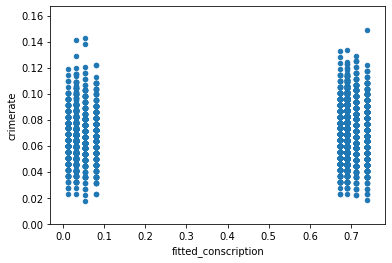

In [89]:
df_regression.plot.scatter(x='fitted_conscription', y='crimerate')

In [53]:
#for i in years:
 #   df[df.cohort == i].plot.scatter(x='sm', y='crimerate')

Figure A.2

In [54]:
#for i in years:
 #   df[df.cohort == i].plot.scatter(x='draftnumber', y='sm')

## 4. Critical Assessment of Quality 

 - Same criticism to Angrist (1990) by Rosenzweig & Wolpin (2000) applicable to this study if mechanism thorugh labour market
 - Positive: they consider a deeper mechanism of conscription on crimerate. But they still go not deep enough.
 - Effect of 'navy': what if navy has otherwise detrimental effects that lead to crime rate to incr.?

Get [back to top](#Content-of-this-Notebook).

## References 

Angrist, Joshua D. 1990. "Lifetime Earnings and the Vietnam Era Draft Lottery: Evidence from Social Security Administrative Records.". *American Economic Review*, Vol. 80, No. 3 (Jun., 1990): 313-336

Galiani, Sebastian, Martín A. Rossi, and Ernesto Schargrodsky. 2011. "Conscription and Crime: Evidence from the Argentine Draft Lottery." *American Economic Journal: Applied Economics*, 3 (2): 119-36.
[DOI: 10.1257/app.3.2.119](http://dx.doi.org/10.1257/app.3.2.119)
            
Pearl, J. 2014. "Causality." Cambridge, England: *Cambridge University Press*.

Rosenzweig, Mark, R., and Kenneth I. Wolpin. 2000. "Natural "Natural Experiments" in Economics." *Journal of Economic Literature*, 38 (4): 827-874.

Winship, C., and Morgan, S. L. 2014. "Counterfactuals and causal inference: Methods and principles for social research." Cambridge, England: *Cambridge University Press*.